In [8]:
# read a mesh from file capacitor.msh
from mpi4py import MPI
from dolfinx.io import gmshio
domain, cell_tags, facet_tags = gmshio.read_from_msh("meshes/rotation/geometry_angle_1.0.msh", MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'meshes/rotation/geometry_angle_1.0.msh'...
Info    : 26 entities
Info    : 72948 nodes
Info    : 145898 elements
Info    : Done reading 'meshes/rotation/geometry_angle_1.0.msh'                                                  


In [9]:
# define finite element function space
from dolfinx.fem import functionspace
import numpy as np
V = functionspace(domain, ("Lagrange", 1))

# identify the boundary (create facet to cell connectivity required to determine boundary facets)
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

# Find facets marked with 2 and 3 (the two rectangles)
facets_rect1 = np.concatenate([facet_tags.find(10), facet_tags.find(11)])
facets_rect2 = facet_tags.find(12)

# Locate degrees of freedom
dofs_rect1 = locate_dofs_topological(V, fdim, facets_rect1)
dofs_rect2 = locate_dofs_topological(V, fdim, facets_rect2)

# Define different Dirichlet values
u_rect1 = Constant(domain, 0.0)
u_rect2 = Constant(domain, 1.0)

# Create BCs
bc1 = dirichletbc(u_rect1, dofs_rect1, V)
bc2 = dirichletbc(u_rect2, dofs_rect2, V)

bcs = [bc1, bc2]

# trial and test functions
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# source term
from dolfinx import default_scalar_type
from dolfinx import fem
f = fem.Constant(domain, default_scalar_type(0.0))

# variational problem
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

# assemble the system
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [10]:
import ufl

# Define the vector function space for the gradient
V_vec = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

# Define the trial and test functions for the vector space
u_vec = ufl.TrialFunction(V_vec)
v_vec = ufl.TestFunction(V_vec)

# Define the gradient of the solution
grad_u = ufl.grad(uh)

# Define the bilinear and linear forms
a_grad = ufl.inner(u_vec, v_vec) * ufl.dx
L_grad = ufl.inner(grad_u, v_vec) * ufl.dx

# Assemble the system
from dolfinx.fem.petsc import LinearProblem
problem_grad = LinearProblem(a_grad, L_grad, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
grad_uh = problem_grad.solve()

In [11]:
# Step 1: Find facets with tag 10
facets10 = facet_tags.find(10)
dofs10 = locate_dofs_topological(V, fdim, facets10)

# Step 2: Extract the x-coordinates and the y-coordinates of the DOFs
x_dofs = V.tabulate_dof_coordinates()[dofs10]
x_coords = x_dofs[:, 0]
print(x_coords.size)
#print(x_coords)
y_coords = x_dofs[:, 1]
print(y_coords.size)
#print(y_coords)

# Step 3: Evaluate grad_uh at those DOFs
dim = domain.geometry.dim
grad_x_uh_values = grad_uh.x.array[0::dim]
grad_y_uh_values = grad_uh.x.array[1::dim]
grad_x_uh_plate = grad_x_uh_values[dofs10]
grad_y_uh_plate = grad_y_uh_values[dofs10]
print(grad_x_uh_plate.size)
#print(grad_y_uh_plate)


794
794
794


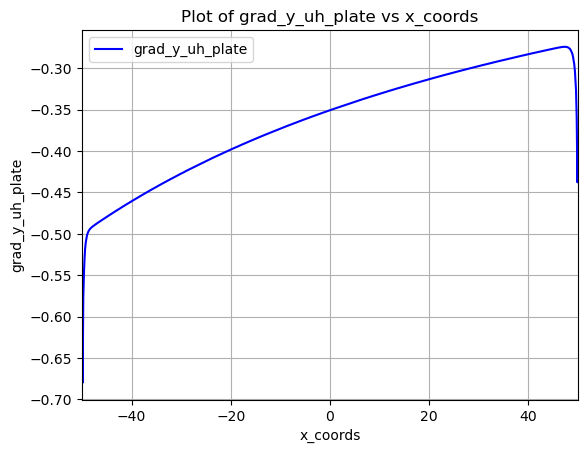

In [12]:
import matplotlib.pyplot as plt
# Plot grad_y_uh_plate against x_coords

# Sort x_coords and apply the same ordering to grad_y_uh_plate
sorted_indices = np.argsort(x_coords)
x_coords = x_coords[sorted_indices]
grad_y_uh_plate = grad_y_uh_plate[sorted_indices]
plt.plot(x_coords, grad_y_uh_plate, label="grad_y_uh_plate", color="blue", linestyle="-")
plt.xlim(-50, 50)
plt.xlabel("x_coords")
plt.ylabel("grad_y_uh_plate")
plt.title("Plot of grad_y_uh_plate vs x_coords")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# plot the mesh 
import pyvista
from dolfinx import plot
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=False)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")


Widget(value='<iframe src="http://localhost:44299/index.html?ui=P_0x7f2bb323dba0_0&reconnect=auto" class="pyvi…

In [14]:
# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:44299/index.html?ui=P_0x7f2b7e09d570_1&reconnect=auto" class="pyvi…

In [15]:
# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_x_uh_values.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:44299/index.html?ui=P_0x7f2b8a928e50_2&reconnect=auto" class="pyvi…

In [16]:
# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_y_uh_values.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:44299/index.html?ui=P_0x7f2b8a928e20_3&reconnect=auto" class="pyvi…

In [17]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=False, show_scalar_bar=True, cmap="coolwarm")
if not pyvista.OFF_SCREEN:
    plotter2.show()

Widget(value='<iframe src="http://localhost:44299/index.html?ui=P_0x7f2b8a937f70_4&reconnect=auto" class="pyvi…

In [18]:
from dolfinx import io
from pathlib import Path
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "fundamentals"
""" with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0) """
with io.VTKFile(domain.comm, filename.with_suffix(".pvd"), "w") as vtk:
    vtk.write_mesh(domain)
    vtk.write_function(uh)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)

In [19]:
# Reate the parameters from innput.txt
import numpy as np

with open("data/input.txt", "r") as f:
    lines = f.readlines()

# Extract sections (single parameter values) from input file
def extract_section(lines, start_marker):
    start = lines.index(start_marker + "\n") + 1
    end = start
    while end < len(lines) and ":" not in lines[end]:
        end += 1
    return np.array([float(line.strip()) for line in lines[start:end]], dtype='float64')

distances = extract_section(lines, "Distances:")
overetches = extract_section(lines, "Overetches:")
angles = extract_section(lines, "Angles (degrees):")

""" print("Distances:", distances)
print("Overetches:", overetches)
print("Angles:", angles)
print("Distances shape:", distances.shape)
print("Overetches shape:", overetches.shape)
print("Angles shape:", angles.shape) """

# Create a np.array of all the combinations of the parameters
from itertools import product
combinations = np.array(list(product(distances, overetches, angles)))
""" print("Combinations of parameters:")
print(combinations.shape)
print(combinations) """

' print("Combinations of parameters:")\nprint(combinations.shape)\nprint(combinations) '

In [20]:
#Save solution in h5 file
import h5py

#true to save the potential, false to save the electric field
sol = True

if sol:
    # Potential
    f = uh
else: 
    # Electric field
    f = grad_uh

""" print(f.shape)
print(f) """

# Step 1: Find facets with tag 30(domain)
facets30 = facet_tags.find(30)
dofs30 = locate_dofs_topological(V, fdim, facets10)

# Step 2: Extract the x-coordinates and the y-coordinates of the DOFs
x_dofs = V.tabulate_dof_coordinates()[dofs30]
x_coords = x_dofs[:, 0]
print(x_coords.size)
#print(x_coords)
y_coords = x_dofs[:, 1]
print(y_coords.size)
#print(y_coords)

# Step 3: Evaluate the function at those DOFs
dim = domain.geometry.dim
if sol:
    fval = np.array(f.x.array[dofs30])
else:
    fval_x = f.x.array[0::dim]
    fval_y = f.x.array[1::dim]
    fval_x_plate = np.array(fval_x[dofs30])
    fval_y_plate = np.array(fval_y[dofs30])

with h5py.File("mesh_data.h5", "w") as file:
    file.create_dataset("coordinates", data=x_dofs)
    if sol:
        file.create_dataset("function_value", data=fval)
    else:
        file.create_dataset("function_value_x", data=fval_x_plate)
        file.create_dataset("function_value_y", data=fval_y_plate)


794
794


OSError: Unable to synchronously create file (unable to truncate a file which is already open)